## Data
All BraTS multimodal scans are available as NIfTI files (.nii.gz) and describe a) native (T1) and b) post-contrast T1-weighted (T1ce), c) T2-weighted (T2), and d) T2 Fluid Attenuated Inversion Recovery (FLAIR) volumes.

Annotations comprise the GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2), and the necrotic and non-enhancing tumor core (NCR/NET — label 1).

## TO-DO
Each pixel must be labeled “1” if it is part of one of the classes (NCR/NET — label 1, ED — label 2, ET — label 4), and “0” if not.

In this notebook, I will use Unet3D for the segmentation

In [4]:
from tqdm import tqdm
import os
import time
from random import randint

import numpy as np
from scipy import stats
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import KFold

import nibabel as nib
import pydicom as pdm
import nilearn as nl
import nilearn.plotting as nlplt
import h5py

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import seaborn as sns
import imageio
from skimage.transform import resize
from skimage.util import montage

from IPython.display import Image as show_gif
from IPython.display import clear_output
from IPython.display import YouTubeVideo

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import MSELoss

import albumentations
import albumentations as A
from albumentations import Compose, HorizontalFlip
import warnings
warnings.simplefilter("ignore")

In [5]:
root = "/home/ardamamur/TUM/ML3D/dataset/"
dataset = root + "train"

In [7]:
sample_filename = dataset + '/BraTS2021_00000/BraTS2021_00000_flair.nii.gz'
sample_filename_mask = dataset + '/BraTS2021_00000/BraTS2021_00000_seg.nii.gz'

sample_img = nib.load(sample_filename)
sample_img = np.asanyarray(sample_img.dataobj)
sample_img = np.rot90(sample_img)
sample_mask = nib.load(sample_filename_mask)
sample_mask = np.asanyarray(sample_mask.dataobj)
sample_mask = np.rot90(sample_mask)
print("img shape ->", sample_img.shape)
print("mask shape ->", sample_mask.shape)

img shape -> (240, 240, 155)
mask shape -> (240, 240, 155)


In [8]:
sample_filename2 = dataset + '/BraTS2021_00000/BraTS2021_00000_t1.nii.gz'
sample_img2 = nib.load(sample_filename2)
sample_img2 = np.asanyarray(sample_img2.dataobj)
sample_img2  = np.rot90(sample_img2)

sample_filename3 = dataset + '/BraTS2021_00000/BraTS2021_00000_t2.nii.gz'
sample_img3 = nib.load(sample_filename3)
sample_img3 = np.asanyarray(sample_img3.dataobj)
sample_img3  = np.rot90(sample_img3)

sample_filename4 = dataset + '/BraTS2021_00000/BraTS2021_00000_t1ce.nii.gz'
sample_img4 = nib.load(sample_filename4)
sample_img4 = np.asanyarray(sample_img4.dataobj)
sample_img4  = np.rot90(sample_img4)

mask_WT = sample_mask.copy()
mask_WT[mask_WT == 1] = 1
mask_WT[mask_WT == 2] = 1
mask_WT[mask_WT == 4] = 1

mask_TC = sample_mask.copy()
mask_TC[mask_TC == 1] = 1
mask_TC[mask_TC == 2] = 0
mask_TC[mask_TC == 4] = 1

mask_ET = sample_mask.copy()
mask_ET[mask_ET == 1] = 0
mask_ET[mask_ET == 2] = 0
mask_ET[mask_ET == 4] = 1

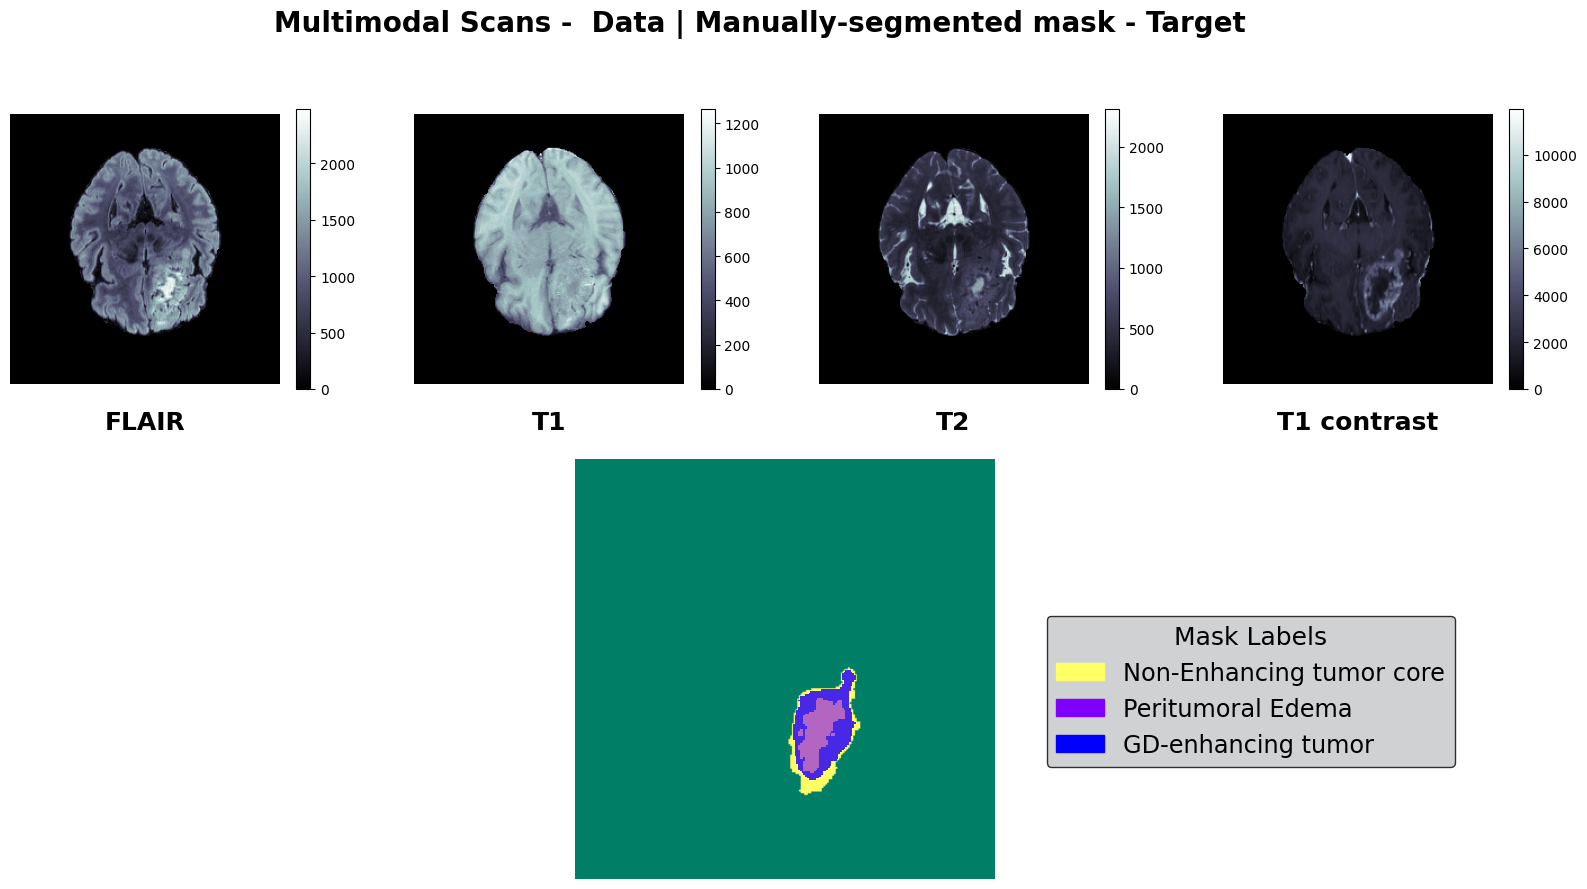

In [9]:
# https://matplotlib.org/3.3.2/gallery/images_contours_and_fields/plot_streamplot.html#sphx-glr-gallery-images-contours-and-fields-plot-streamplot-py
# https://stackoverflow.com/questions/25482876/how-to-add-legend-to-imshow-in-matplotlib
fig = plt.figure(figsize=(20, 10))

gs = gridspec.GridSpec(nrows=2, ncols=4, height_ratios=[1, 1.5])

#  Varying density along a streamline
ax0 = fig.add_subplot(gs[0, 0])
flair = ax0.imshow(sample_img[:,:,65], cmap='bone')
ax0.set_title("FLAIR", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(flair)

#  Varying density along a streamline
ax1 = fig.add_subplot(gs[0, 1])
t1 = ax1.imshow(sample_img2[:,:,65], cmap='bone')
ax1.set_title("T1", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t1)

#  Varying density along a streamline
ax2 = fig.add_subplot(gs[0, 2])
t2 = ax2.imshow(sample_img3[:,:,65], cmap='bone')
ax2.set_title("T2", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t2)

#  Varying density along a streamline
ax3 = fig.add_subplot(gs[0, 3])
t1ce = ax3.imshow(sample_img4[:,:,65], cmap='bone')
ax3.set_title("T1 contrast", fontsize=18, weight='bold', y=-0.2)
fig.colorbar(t1ce)

#  Varying density along a streamline
ax4 = fig.add_subplot(gs[1, 1:3])

#ax4.imshow(np.ma.masked_where(mask_WT[:,:,65]== False,  mask_WT[:,:,65]), cmap='summer', alpha=0.6)
l1 = ax4.imshow(mask_WT[:,:,65], cmap='summer',)
l2 = ax4.imshow(np.ma.masked_where(mask_TC[:,:,65]== False,  mask_TC[:,:,65]), cmap='rainbow', alpha=0.6)
l3 = ax4.imshow(np.ma.masked_where(mask_ET[:,:,65] == False, mask_ET[:,:,65]), cmap='winter', alpha=0.6)

ax4.set_title("", fontsize=20, weight='bold', y=-0.1)

_ = [ax.set_axis_off() for ax in [ax0,ax1,ax2,ax3, ax4]]

colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]
labels = ['Non-Enhancing tumor core', 'Peritumoral Edema ', 'GD-enhancing tumor']
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 'xx-large',
           title='Mask Labels', title_fontsize=18, edgecolor="black",  facecolor='#c5c6c7')

plt.suptitle("Multimodal Scans -  Data | Manually-segmented mask - Target", fontsize=20, weight='bold')

fig.savefig("data_sample.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("data_sample.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

In [25]:
def get_augmentations(phase):
    list_transforms = []
    
    list_trfms = Compose(list_transforms)
    return list_trfms

In [40]:
class BratsDataset(Dataset):
    def __init__(self, root, patient_ids, phase, is_resize: bool=False):
        self.root = root
        self.patient_ids = patient_ids
        self.phase = phase
        self.augmentations = get_augmentations(phase)
        self.scan_types = ['flair', 't1', 't1ce', 't2']
        self.is_resize = is_resize
        
    def __len__(self):
        return len(self.patient_ids)
    
    def __getitem__(self, idx):
        patient_id = self.patient_ids[idx]
        id_ = patient_id
        # load all modalities
        images = []
        for scan_type in self.scan_types:
            img_path = f'{self.root}/BraTS2021_{patient_id}/BraTS2021_{patient_id}_{scan_type}.nii.gz'
            img = self.load_img(img_path) #.transpose(2, 0, 1)
            
            if self.is_resize:
                img = self.resize(img)
    
            img = self.normalize(img)
            images.append(img)
        img = np.stack(images)
        img = np.moveaxis(img, (0, 1, 2, 3), (0, 3, 2, 1))
        
        if self.phase != "test":
            mask_path =  f'{self.root}/BraTS2021_{patient_id}/BraTS2021_{patient_id}_seg.nii.gz'
            mask = self.load_img(mask_path)
            
            if self.is_resize:
                mask = self.resize(mask)
                mask = np.clip(mask.astype(np.uint8), 0, 1).astype(np.float32)
                mask = np.clip(mask, 0, 1)
            mask = self.preprocess_mask_labels(mask)
    
            augmented = self.augmentations(image=img.astype(np.float32), 
                                           mask=mask.astype(np.float32))
            
            img = augmented['image']
            mask = augmented['mask']
        
            return {
                "Id": id_,
                "image": img,
                "mask": mask,
            }
        
        return {
            "Id": id_,
            "image": img,
        }
    
    def load_img(self, file_path):
        data = nib.load(file_path)
        data = np.asarray(data.dataobj)
        return data
    
    def normalize(self, data: np.ndarray):
        data_min = np.min(data)
        return (data - data_min) / (np.max(data) - data_min)
    
    def resize(self, data: np.ndarray):
        data = resize(data, (78, 120, 120), preserve_range=True)
        return data
    
    def preprocess_mask_labels(self, mask: np.ndarray):

        mask_WT = mask.copy()
        mask_WT[mask_WT == 1] = 1
        mask_WT[mask_WT == 2] = 1
        mask_WT[mask_WT == 4] = 1

        mask_TC = mask.copy()
        mask_TC[mask_TC == 1] = 1
        mask_TC[mask_TC == 2] = 0
        mask_TC[mask_TC == 4] = 1

        mask_ET = mask.copy()
        mask_ET[mask_ET == 1] = 0
        mask_ET[mask_ET == 2] = 0
        mask_ET[mask_ET == 4] = 1

        mask = np.stack([mask_WT, mask_TC, mask_ET])
        mask = np.moveaxis(mask, (0, 1, 2, 3), (0, 3, 2, 1))

        return mask

In [44]:
def get_dataloader(
    dataset: torch.utils.data.Dataset,
    root: str,
    phase: str,
    fold: int = 0,
    batch_size: int = 1,
    num_workers: int = 0,
):

    ids = [d.split("_")[-1] for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
    train_ids, eval_ids = train_test_split(ids, test_size=0.2, random_state=42)
    val_ids, test_ids = train_test_split(eval_ids, test_size=0.1, random_state=42)
    
    patient_ids = train_ids if phase == "train" else val_ids
    
    dataset = dataset(root, patient_ids, phase)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,   
    )
    return dataloader

In [45]:
root = "/home/ardamamur/TUM/ML3D/dataset/train"
dataloader = get_dataloader(dataset=BratsDataset, root=root, phase='train', fold=0)
len(dataloader)

1000

In [46]:
data = next(iter(dataloader))
data['Id'], data['image'].shape, data['mask'].shape

(['01219'],
 torch.Size([1, 4, 155, 240, 240]),
 torch.Size([1, 3, 155, 240, 240]))

Num uniq Image values : 1180
Min/Max Image values: 0.0 1.0
Num uniq Mask values: (array([0., 1.], dtype=float32), array([8797660,  130340]))


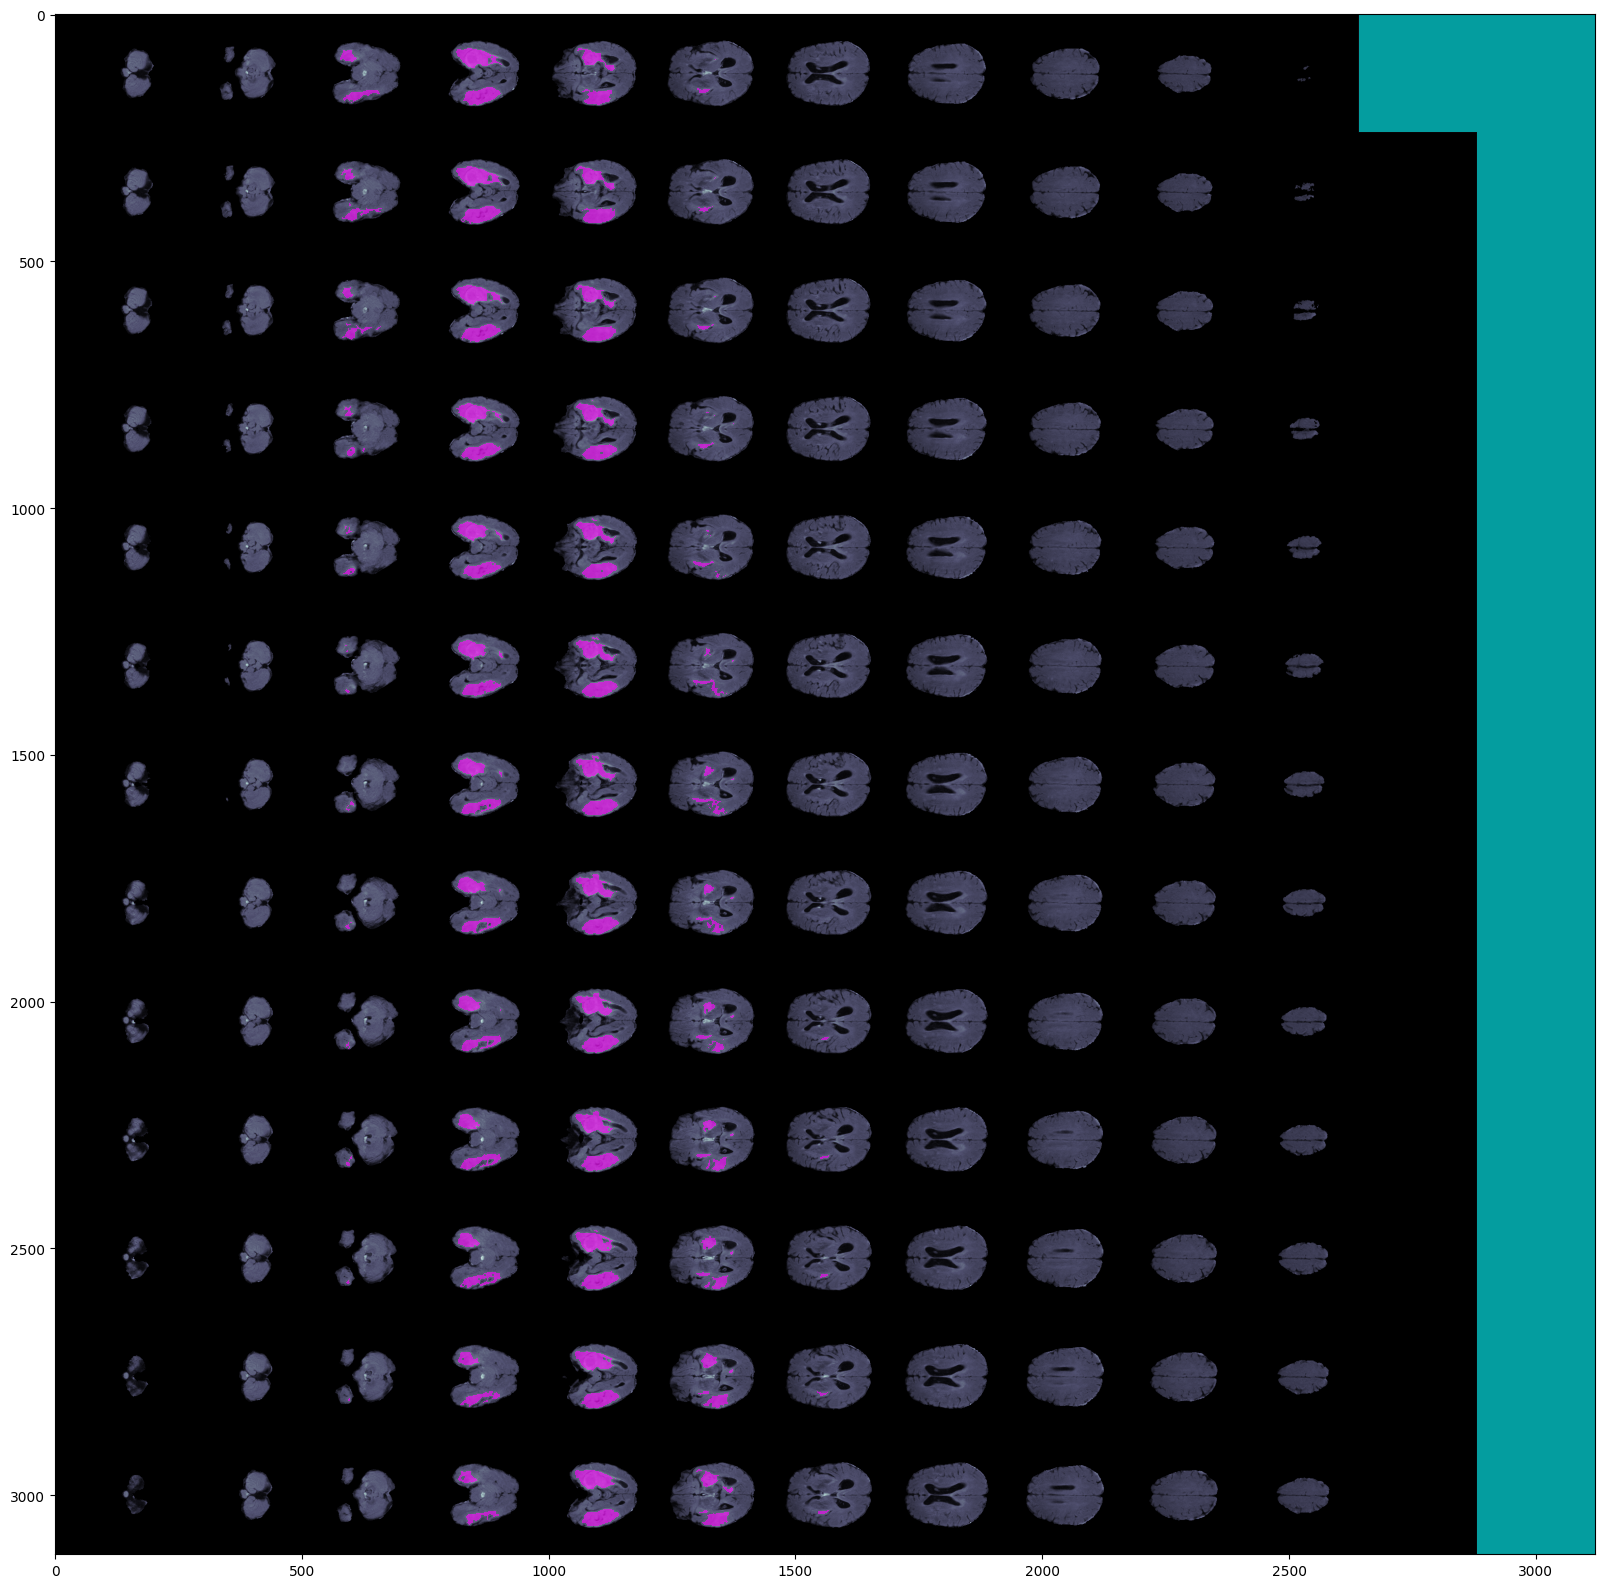

In [47]:
img_tensor = data['image'].squeeze()[0].cpu().detach().numpy() 
mask_tensor = data['mask'].squeeze()[0].squeeze().cpu().detach().numpy()
print("Num uniq Image values :", len(np.unique(img_tensor, return_counts=True)[0]))
print("Min/Max Image values:", img_tensor.min(), img_tensor.max())
print("Num uniq Mask values:", np.unique(mask_tensor, return_counts=True))

image = np.rot90(montage(img_tensor))
mask = np.rot90(montage(mask_tensor)) 

fig, ax = plt.subplots(1, 1, figsize = (20, 20))
ax.imshow(image, cmap ='bone')
ax.imshow(np.ma.masked_where(mask == False, mask),
           cmap='cool', alpha=0.6)

## Loss and Metrics


In [48]:
def dice_coef_metric(probabilities: torch.Tensor,
                     truth: torch.Tensor,
                     treshold: float = 0.5,
                     eps: float = 1e-9) -> np.ndarray:
    """
    Calculate Dice score for data batch.
    Params:
        probobilities: model outputs after activation function.
        truth: truth values.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        Returns: dice score aka f1.
    """
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = 2.0 * (truth_ * prediction).sum()
        union = truth_.sum() + prediction.sum()
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)


def jaccard_coef_metric(probabilities: torch.Tensor,
               truth: torch.Tensor,
               treshold: float = 0.5,
               eps: float = 1e-9) -> np.ndarray:
    """
    Calculate Jaccard index for data batch.
    Params:
        probobilities: model outputs after activation function.
        truth: truth values.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        Returns: jaccard score aka iou."
    """
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)

    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = (prediction * truth_).sum()
        union = (prediction.sum() + truth_.sum()) - intersection + eps
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)


class Meter:
    '''factory for storing and updating iou and dice scores.'''
    def __init__(self, treshold: float = 0.5):
        self.threshold: float = treshold
        self.dice_scores: list = []
        self.iou_scores: list = []
    
    def update(self, logits: torch.Tensor, targets: torch.Tensor):
        """
        Takes: logits from output model and targets,
        calculates dice and iou scores, and stores them in lists.
        """
        probs = torch.sigmoid(logits)
        dice = dice_coef_metric(probs, targets, self.threshold)
        iou = jaccard_coef_metric(probs, targets, self.threshold)
        
        self.dice_scores.append(dice)
        self.iou_scores.append(iou)
    
    def get_metrics(self) -> np.ndarray:
        """
        Returns: the average of the accumulated dice and iou scores.
        """
        dice = np.mean(self.dice_scores)
        iou = np.mean(self.iou_scores)
        return dice, iou


class DiceLoss(nn.Module):
    """Calculate dice loss."""
    def __init__(self, eps: float = 1e-9):
        super(DiceLoss, self).__init__()
        self.eps = eps
        
    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        
        num = targets.size(0)
        probability = torch.sigmoid(logits)
        probability = probability.view(num, -1)
        targets = targets.view(num, -1)
        assert(probability.shape == targets.shape)
        
        intersection = 2.0 * (probability * targets).sum()
        union = probability.sum() + targets.sum()
        dice_score = (intersection + self.eps) / union
        #print("intersection", intersection, union, dice_score)
        return 1.0 - dice_score
        
        
class BCEDiceLoss(nn.Module):
    """Compute objective loss: BCE loss + DICE loss."""
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        
    def forward(self, 
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        assert(logits.shape == targets.shape)
        dice_loss = self.dice(logits, targets)
        bce_loss = self.bce(logits, targets)
        
        return bce_loss + dice_loss
    
# helper functions for testing.  
def dice_coef_metric_per_classes(probabilities: np.ndarray,
                                    truth: np.ndarray,
                                    treshold: float = 0.5,
                                    eps: float = 1e-9,
                                    classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:
    """
    Calculate Dice score for data batch and for each class.
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with dice scores for each class.
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = 2.0 * (truth_ * prediction).sum()
            union = truth_.sum() + prediction.sum()
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)
                
    return scores


def jaccard_coef_metric_per_classes(probabilities: np.ndarray,
               truth: np.ndarray,
               treshold: float = 0.5,
               eps: float = 1e-9,
               classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:
    """
    Calculate Jaccard index for data batch and for each class.
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with jaccard scores for each class."
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = (prediction * truth_).sum()
            union = (prediction.sum() + truth_.sum()) - intersection + eps
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores